# 준비

## 라이브러리 호출

In [1]:
from tensorflow.keras import layers, models, utils, optimizers, callbacks, losses
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [27]:
from Myfunc import show_lcurve, show_history_concat

## 데이터 셋

In [77]:
BATCH_SIZE = 32
IMAGE_SIZE = (160, 160)

train_ds = image_dataset_from_directory("../../dataset/cats_and_dogs/new_ds/train/",
                                       shuffle=True,
                                       batch_size=BATCH_SIZE,
                                       image_size=IMAGE_SIZE)
valid_ds = image_dataset_from_directory("../../dataset/cats_and_dogs/new_ds/valid",
                                       shuffle=True,
                                       batch_size=BATCH_SIZE,
                                       image_size=IMAGE_SIZE)
test_ds = image_dataset_from_directory("../../dataset/cats_and_dogs/new_ds/test",
                                       batch_size=BATCH_SIZE,
                                       image_size=IMAGE_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## 데이터 셋 살펴보기

In [78]:
class_names = train_ds.class_names

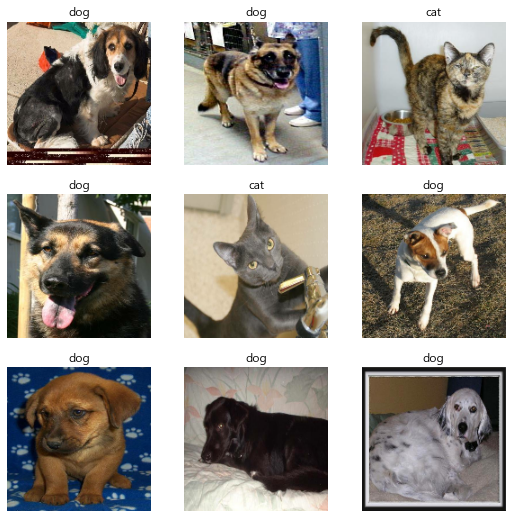

In [3]:
plt.figure(figsize=(9,9))
for image, label in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_name[label[i]])
        plt.axis("off")

## 데이터셋 튜닝

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## 데이터셋 증강

In [4]:
def data_augmentation(x):
    y = layers.experimental.preprocessing.RandomFlip('horizontal')(x)
    y = layers.experimental.preprocessing.RandomWidth(0.2)(y)
    y = layers.experimental.preprocessing.RandomHeight(0.2)(y)
    y = layers.experimental.preprocessing.RandomZoom(0.2)(y)
    y = layers.experimental.preprocessing.RandomRotation(0.2)(y)
    return y

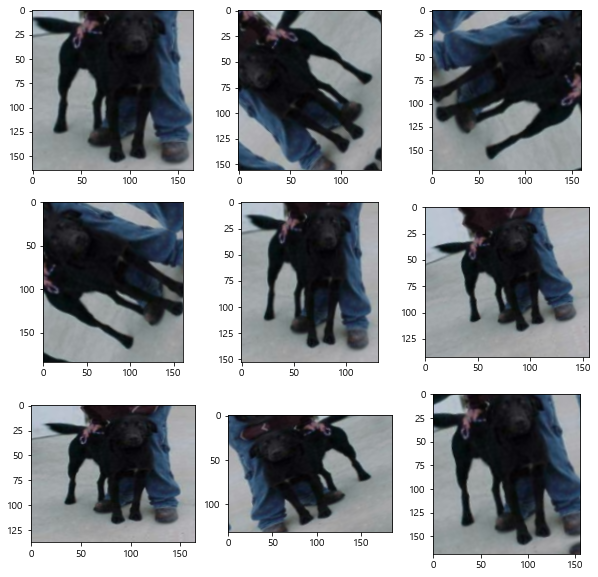

In [7]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)

# 전이학습

## 전이학습 준비

In [5]:
# 베이스 모델에 포함되어있는 전처리 메서드를 가저옴
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [6]:
# MobileNet 은 [0,1] 예측이 아닌 [-1, 1] 예측이다.
# 따라서 [0, 255] 를 [0, 2] 로 만든뒤 -1 오프셋 하여 [-1, 1] 로 만든다.
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [7]:
IMAGE_SHAPE = IMAGE_SIZE + (3, ) # IMAGE_SIZE = (160, 160) -> IMAGE_SHAPE = (160,160, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False # 베이스 모델은 학습하지 않음

In [8]:
# (160, 160, 3) -> (5,5, 1280) 의 특성 블럭으로 변환하는 base_model 
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(image_batch.shape, feature_batch.shape)

(32, 160, 160, 3) (32, 5, 5, 1280)


In [9]:
# (5,5) 의 2차원(H x W) 을 1개의 값으로 변환하는 GAP
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [10]:
# 1280개의 특성을 이용하여 1개의 값으로 변환 음수는 0, 양수는 1로 예측
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


## 전이 학습 모델링

In [11]:
def transfer_model_build():
    x = layers.Input(shape=IMAGE_SHAPE)
    y = data_augmentation(x)
    y = preprocess_input(y)
    y = base_model(y, training=False)
    y = global_average_layer(y)
    y = layers.Dropout(0.2)(y)
    y = prediction_layer(y)
    return models.Model(x, y)

transfer_model = transfer_model_build()

optimizer = optimizers.RMSprop(learning_rate=0.0001)
loss = losses.BinaryCrossentropy(from_logits=True)
metric = ["acc"]

transfer_model.compile(optimizer=optimizer, loss=loss, metrics=metric)

## 전이학습

In [13]:
history = transfer_model.fit(train_ds,
                    epochs=10,
                    validation_data=valid_ds)

Epoch 1/10
63/63 [==============================] - 44s 642ms/step - loss: 0.9439 - acc: 0.4687 - val_loss: 0.6142 - val_acc: 0.6530
Epoch 2/10
63/63 [==============================] - 28s 445ms/step - loss: 0.6930 - acc: 0.6296 - val_loss: 0.4435 - val_acc: 0.7880
Epoch 3/10
63/63 [==============================] - 28s 444ms/step - loss: 0.5313 - acc: 0.7356 - val_loss: 0.3380 - val_acc: 0.8600
Epoch 4/10
63/63 [==============================] - 26s 399ms/step - loss: 0.4323 - acc: 0.7776 - val_loss: 0.2679 - val_acc: 0.9070
Epoch 5/10
63/63 [==============================] - 25s 390ms/step - loss: 0.3721 - acc: 0.8208 - val_loss: 0.2229 - val_acc: 0.9150
Epoch 6/10
63/63 [==============================] - 22s 341ms/step - loss: 0.3627 - acc: 0.8332 - val_loss: 0.1927 - val_acc: 0.9300
Epoch 7/10
63/63 [==============================] - 23s 370ms/step - loss: 0.3155 - acc: 0.8543 - val_loss: 0.1709 - val_acc: 0.9330
Epoch 8/10
63/63 [==============================] - 23s 357ms/step - 

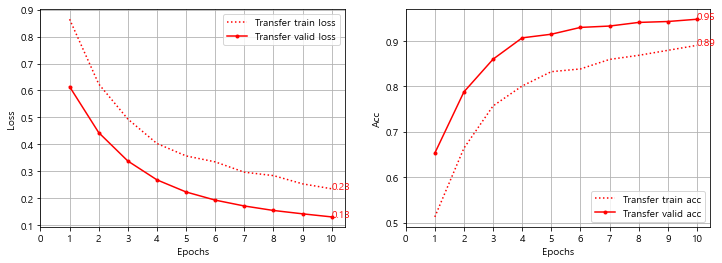

In [19]:
show_lcurve([history], ["Transfer"],["r"])

## 평가 및 예측

In [22]:
transfer_model.evaluate(test_ds)

32/32 [==============================] - 6s 149ms/step - loss: 0.1389 - acc: 0.9510 1s - loss: 0.1390 - ac


[0.1388687640428543, 0.9509999752044678]

# 미세조정 학습

## 미세조정 준비

In [23]:
# base_model 고정 해제
base_model.trainable = True

In [24]:
# 1~100 층 layer는 고정
for layer in base_model.layers[:100]:
    layer.trainable = False

In [25]:
transfer_model.compile(loss=loss, optimizer=optimizer, metrics=metric)

In [26]:
history_fine = transfer_model.fit(train_ds,
                                  epochs=20,
                                  initial_epoch=10,
                                  validation_data=valid_ds)

Epoch 11/20
63/63 [==============================] - 33s 438ms/step - loss: 0.6812 - acc: 0.7789 - val_loss: 0.1564 - val_acc: 0.9660
Epoch 12/20
63/63 [==============================] - 22s 347ms/step - loss: 0.2559 - acc: 0.8916 - val_loss: 0.0783 - val_acc: 0.9840
Epoch 13/20
63/63 [==============================] - 23s 353ms/step - loss: 0.2154 - acc: 0.9139 - val_loss: 0.1022 - val_acc: 0.9480
Epoch 14/20
63/63 [==============================] - 23s 357ms/step - loss: 0.1869 - acc: 0.9245 - val_loss: 0.1362 - val_acc: 0.9550
Epoch 15/20
63/63 [==============================] - 23s 357ms/step - loss: 0.2436 - acc: 0.9026 - val_loss: 0.0575 - val_acc: 0.9750
Epoch 16/20
63/63 [==============================] - 23s 365ms/step - loss: 0.1683 - acc: 0.9288 - val_loss: 0.0492 - val_acc: 0.9840
Epoch 17/20
63/63 [==============================] - 23s 360ms/step - loss: 0.1432 - acc: 0.9372 - val_loss: 0.0592 - val_acc: 0.9810
Epoch 18/20
63/63 [==============================] - 24s 367ms

In [68]:
def show_history_concat(hists, x_itv=2):
    """
    hists : 합쳐야할 히스토리들

    """
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    split_line = []

    for hist in hists:
        acc += hist.history['acc']
        val_acc += hist.history['val_acc']
        loss += hist.history['loss']
        val_loss += hist.history['val_loss']
        split_line.append(len(hist.history['acc']))
    
    epochs = range(1, 1+len(loss))
    xbins = range(0, len(loss)+1, x_itv)
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    for i in split_line:
        plt.plot([i,i],plt.ylim())
    plt.legend(loc='upper right');plt.grid(True);plt.xticks(xbins)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs');plt.ylabel('loss')
    x, y = epochs[-1], loss[-1]
    plt.text(x, y, np.round(y,2), c="k")
    x, y = epochs[-1], val_loss[-1]
    plt.text(x, y, np.round(y,2), c="k")
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    for i in split_line:
        plt.plot([i,i], plt.ylim())
    plt.legend(loc='lower right');plt.grid(True);plt.xticks(xbins)
    plt.xlabel('Epochs');plt.ylabel('Acc')
    plt.title('Training and Validation Accuracy')
    x, y = epochs[-1], acc[-1]
    plt.text(x, y, np.round(y,2), c="k")
    x, y = epochs[-1], val_acc[-1]
    plt.text(x, y, np.round(y,2), c="k")

    plt.show()

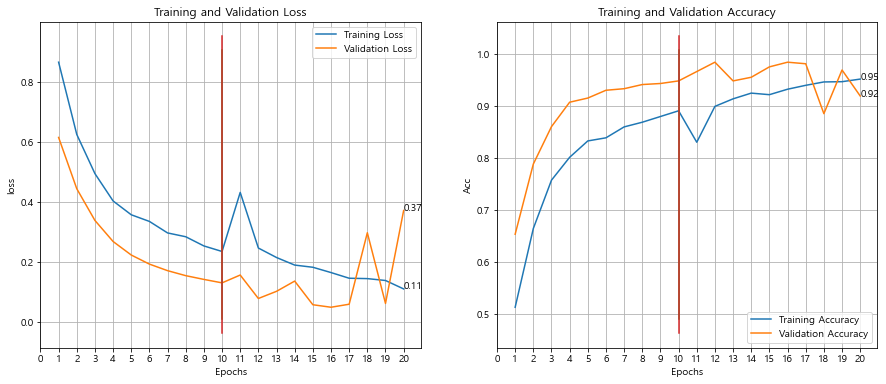

In [69]:
show_history_concat([history, history_fine], x_itv=1)

## 평가 및 예측

In [70]:
loss, accuracy = transfer_model.evaluate(test_ds)
print('Test accuracy :', accuracy)

32/32 [==============================] - 4s 109ms/step - loss: 0.3793 - acc: 0.9130
Test accuracy : 0.9129999876022339


Predictions:
 [0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1]
Labels:
 [0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1]


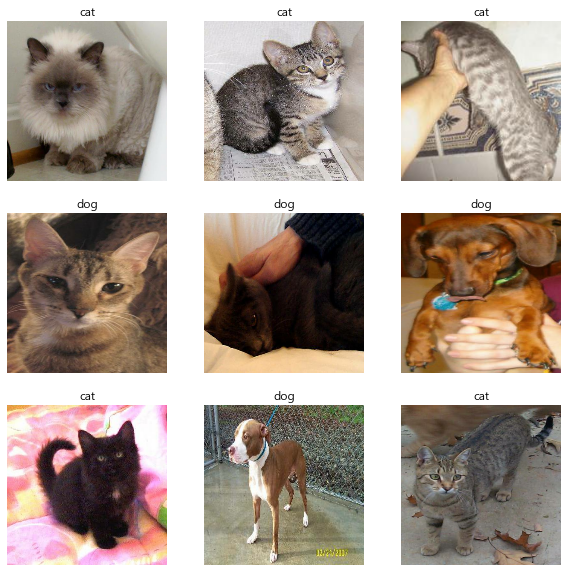

In [79]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = transfer_model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")